In [1]:
!pip install pyspark
!pip install findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=b95c5241696546e53ddf2952e04850f4c23b8e6a00a05478a5b788ba296f1bf9
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd /content/drive/MyDrive/Farhad/

/content/drive/MyDrive/Farhad


In [4]:
#!unzip gas+sensor+array+temperature+modulation.zip

In [5]:
!unzip gas-sensor-array-temperature-modulation.zip

Archive:  gas-sensor-array-temperature-modulation.zip
replace 20161005_140846.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### PySpark Machine Learning Pipeline
This notebook demonstrates the construction of a machine learning pipeline using PySpark. I'll preprocess data, engineer features, train various classifiers such as Naive Bayes and Decision Trees, and evaluate their performance. Essential libraries like Pandas, Matplotlib, Seaborn, and Scikit-learn are also utilized for data manipulation and visualization. By the end, I'll have a comprehensive understanding of building and evaluating machine learning models in a distributed computing environment.

In [6]:
import os
from datetime import datetime

import pandas as pd

import findspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
findspark.init()

from pyspark.ml.feature import CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover, OneHotEncoder
from pyspark.sql.functions import col, udf, regexp_replace, isnull, isnan, when, count
from pyspark.ml.feature import StandardScaler
from pyspark.sql.types import StringType,IntegerType
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F


from sklearn.model_selection import train_test_split, GridSearchCV
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes

from sklearn.pipeline import Pipeline
from pyspark.ml.pipeline import Pipeline


from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
os.listdir()

['README.txt',
 '20161013_143355.csv',
 '20161004_104124.csv',
 '20160930_203718.csv',
 '20161001_231809.csv',
 '20161003_085624.csv',
 '20161005_140846.csv',
 '20161006_182224.csv',
 '20161007_210049.csv',
 '20161008_234508.csv',
 '20161010_095046.csv',
 '20161011_113032.csv',
 '20161016_053656.csv',
 '20161014_184659.csv',
 'gas-sensor-array-temperature-modulation.zip',
 '.ipynb_checkpoints']

### Listing CSV Files in the Current Directory
The provided code snippet utilizes Python's os.listdir() function to list all files in the current directory. It then filters the list to include only those files ending with the .csv extension using a list comprehension. The resulting list, files, contains the filenames of all CSV files present in the directory.

In [8]:
files = [f for f in os.listdir() if f.endswith('.csv')]

files

['20161013_143355.csv',
 '20161004_104124.csv',
 '20160930_203718.csv',
 '20161001_231809.csv',
 '20161003_085624.csv',
 '20161005_140846.csv',
 '20161006_182224.csv',
 '20161007_210049.csv',
 '20161008_234508.csv',
 '20161010_095046.csv',
 '20161011_113032.csv',
 '20161016_053656.csv',
 '20161014_184659.csv']

### Creating a Spark Session
The provided code initializes a Spark session using PySpark. It sets the master node to run locally (master("local")), assigns the application name as "gasSensor" (appName("gasSensor")), and configures the executor memory to 1GB (config("spark.executor.memory", "1gb")). The SparkSession.builder object is used to configure and create the Spark session, and getOrCreate() ensures that if a Spark session already exists, it will be returned; otherwise, a new one will be created.

In [9]:
spark = SparkSession.builder.master("local").appName("gasSensor").config("spark.executor.memory", "1gb").getOrCreate()

In [10]:
sc = spark.sparkContext

In [11]:
ls

20160930_203718.csv  20161006_182224.csv  20161013_143355.csv
20161001_231809.csv  20161007_210049.csv  20161014_184659.csv
20161003_085624.csv  20161008_234508.csv  20161016_053656.csv
20161004_104124.csv  20161010_095046.csv  gas-sensor-array-temperature-modulation.zip
20161005_140846.csv  20161011_113032.csv  README.txt


### Merging CSV Files into a Single DataFrame
The provided code iterates through a list of CSV files (files) in the current directory. For each file, it extracts the date and time from the filename, reads the CSV file into a Spark DataFrame (df), and formats the 'Time (s)' column to include the date. If merge_df is None, it assigns merge_df to the DataFrame df; otherwise, it merges df with merge_df using the union() function.

In [12]:
merge_df = None

for f in files:
  date_time = f.split('.')[0]
  format_string = "%Y%m%d_%H%M%S"

  date_time_obj = datetime.strptime(date_time, format_string)
  date = date_time_obj.strftime('%Y-%m-%d ')

  df = spark.read.csv(f, inferSchema='True', header = 'True')

  df = df.withColumn('Time (s)', F.concat(F.lit(date), F.col('Time (s)')))

  if merge_df is None:
    merge_df = df
  else:
    merge_df = merge_df.union(df)

In [13]:
merge_df.count()

3843160

In [14]:
sampled_df = merge_df.sample(fraction=0.1, withReplacement=False, seed=42)
a = sampled_df.toPandas()

In [15]:
a.head()

,Time (s),CO (ppm),Humidity (%r.h.),Temperature (C),Flow rate (mL/min),Heater voltage (V),R1 (MOhm),R2 (MOhm),R3 (MOhm),R4 (MOhm),R5 (MOhm),R6 (MOhm),R7 (MOhm),R8 (MOhm),R9 (MOhm),R10 (MOhm),R11 (MOhm),R12 (MOhm),R13 (MOhm),R14 (MOhm)
0,2016-10-13 2.16,0.0,83.81,25.38,240.8351,0.8980,0.0891,0.1382,0.1179,0.1005,0.1171,0.1191,0.1246,0.0952,0.0983,0.1152,0.1062,0.1060,0.0988,0.1046
1,2016-10-13 4.942,0.0,83.81,25.38,240.1993,0.2086,3.7298,8.2674,13.1529,6.0058,11.8716,12.7666,14.4640,6.6633,3.8494,6.8522,7.6493,8.5120,4.9330,9.7929
2,2016-10-13 5.56,0.0,83.81,25.38,240.0695,0.2040,32.2705,35.0387,55.9066,12.5126,42.6025,50.4951,36.4079,15.6132,4.8126,14.9881,15.0335,14.7836,6.5424,15.4479
3,2016-10-13 15.444,0.0,83.81,25.38,239.7010,0.2000,0.4155,0.4904,0.5689,2.3545,2.0411,1.7317,2.2518,12.8942,4.6658,13.9241,20.0809,13.0191,5.3660,13.9305
4,2016-10-13 17.912,0.0,83.81,25.38,239.9186,0.1992,0.3415,0.4277,0.4580,1.2011,0.9768,1.0154,1.1235,11.6055,4.5024,11.9715,18.4471,11.7190,4.7111,11.7697


In [16]:
b = a.iloc[:, :4]

In [17]:
b.head()

,Time (s),CO (ppm),Humidity (%r.h.),Temperature (C)
0,2016-10-13 2.16,0.0,83.81,25.38
1,2016-10-13 4.942,0.0,83.81,25.38
2,2016-10-13 5.56,0.0,83.81,25.38
3,2016-10-13 15.444,0.0,83.81,25.38
4,2016-10-13 17.912,0.0,83.81,25.38


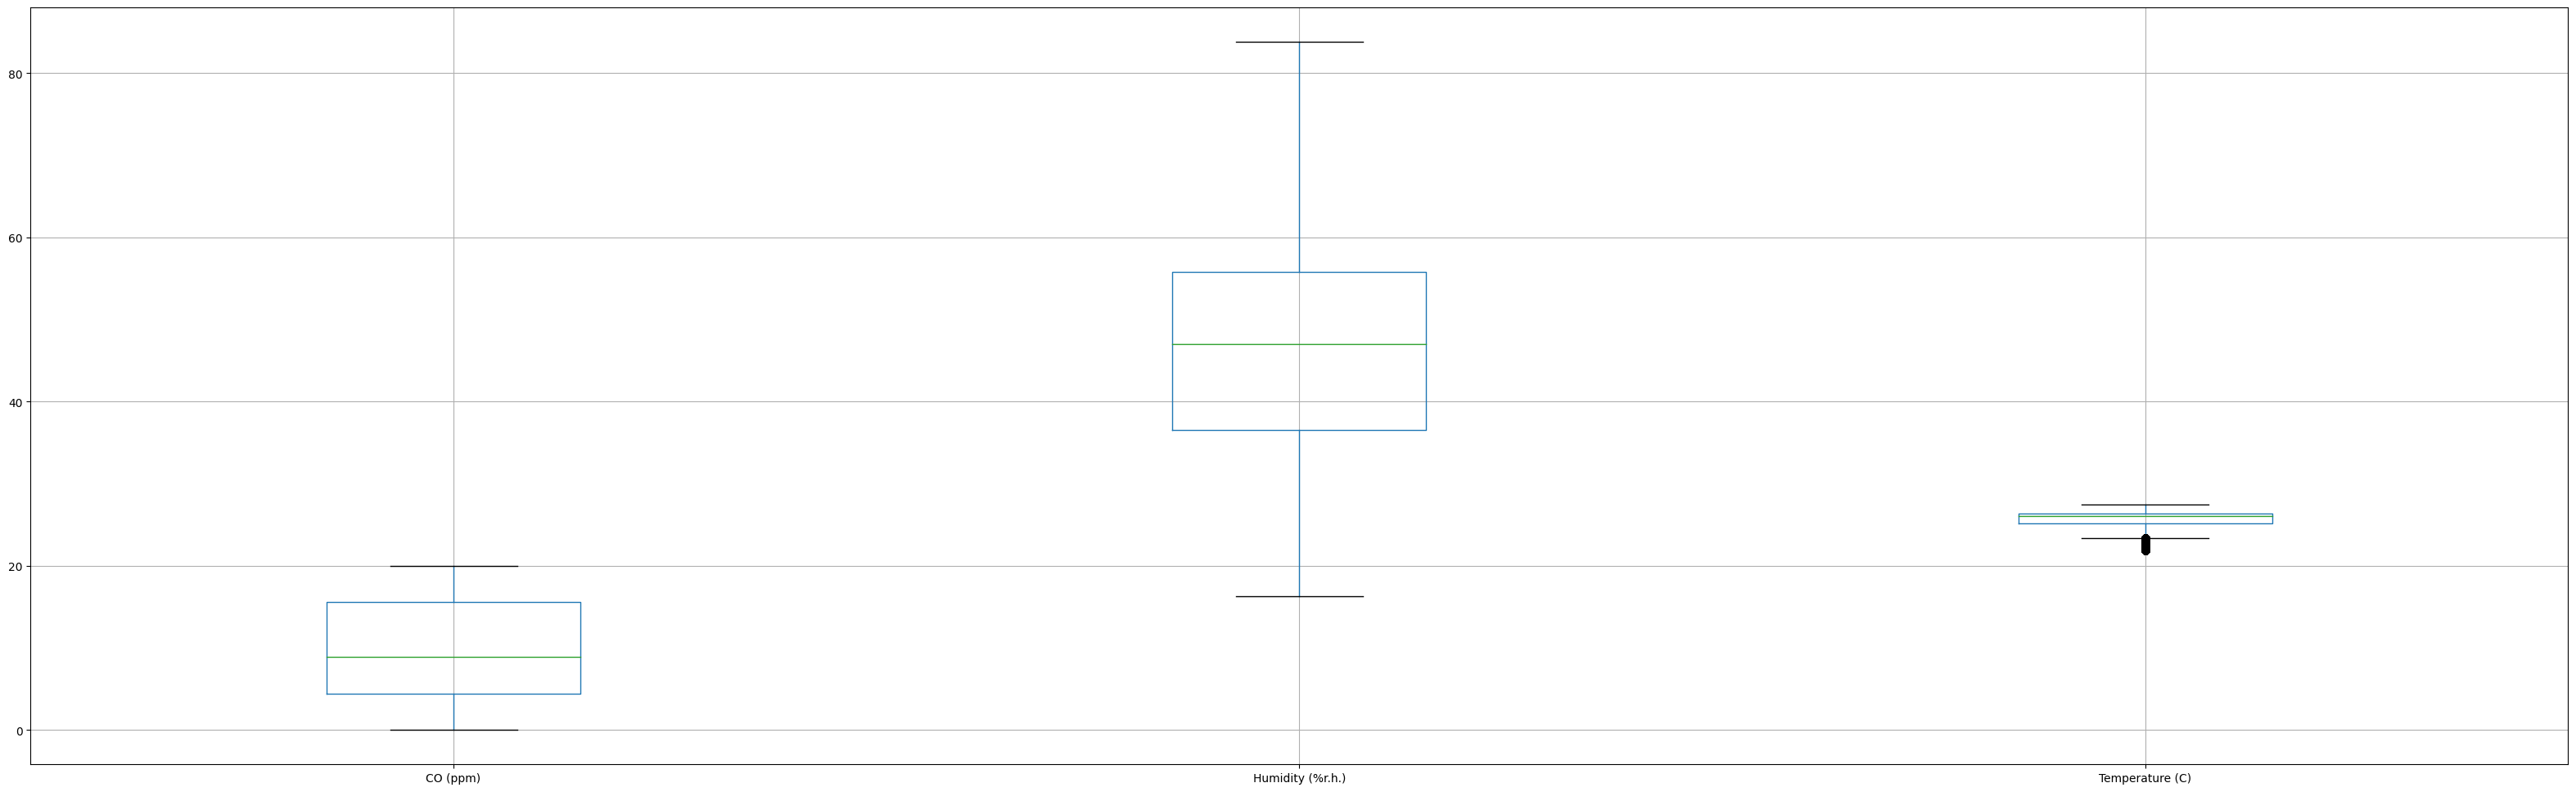

In [18]:
boxplot = b.boxplot(figsize=(40, 12))

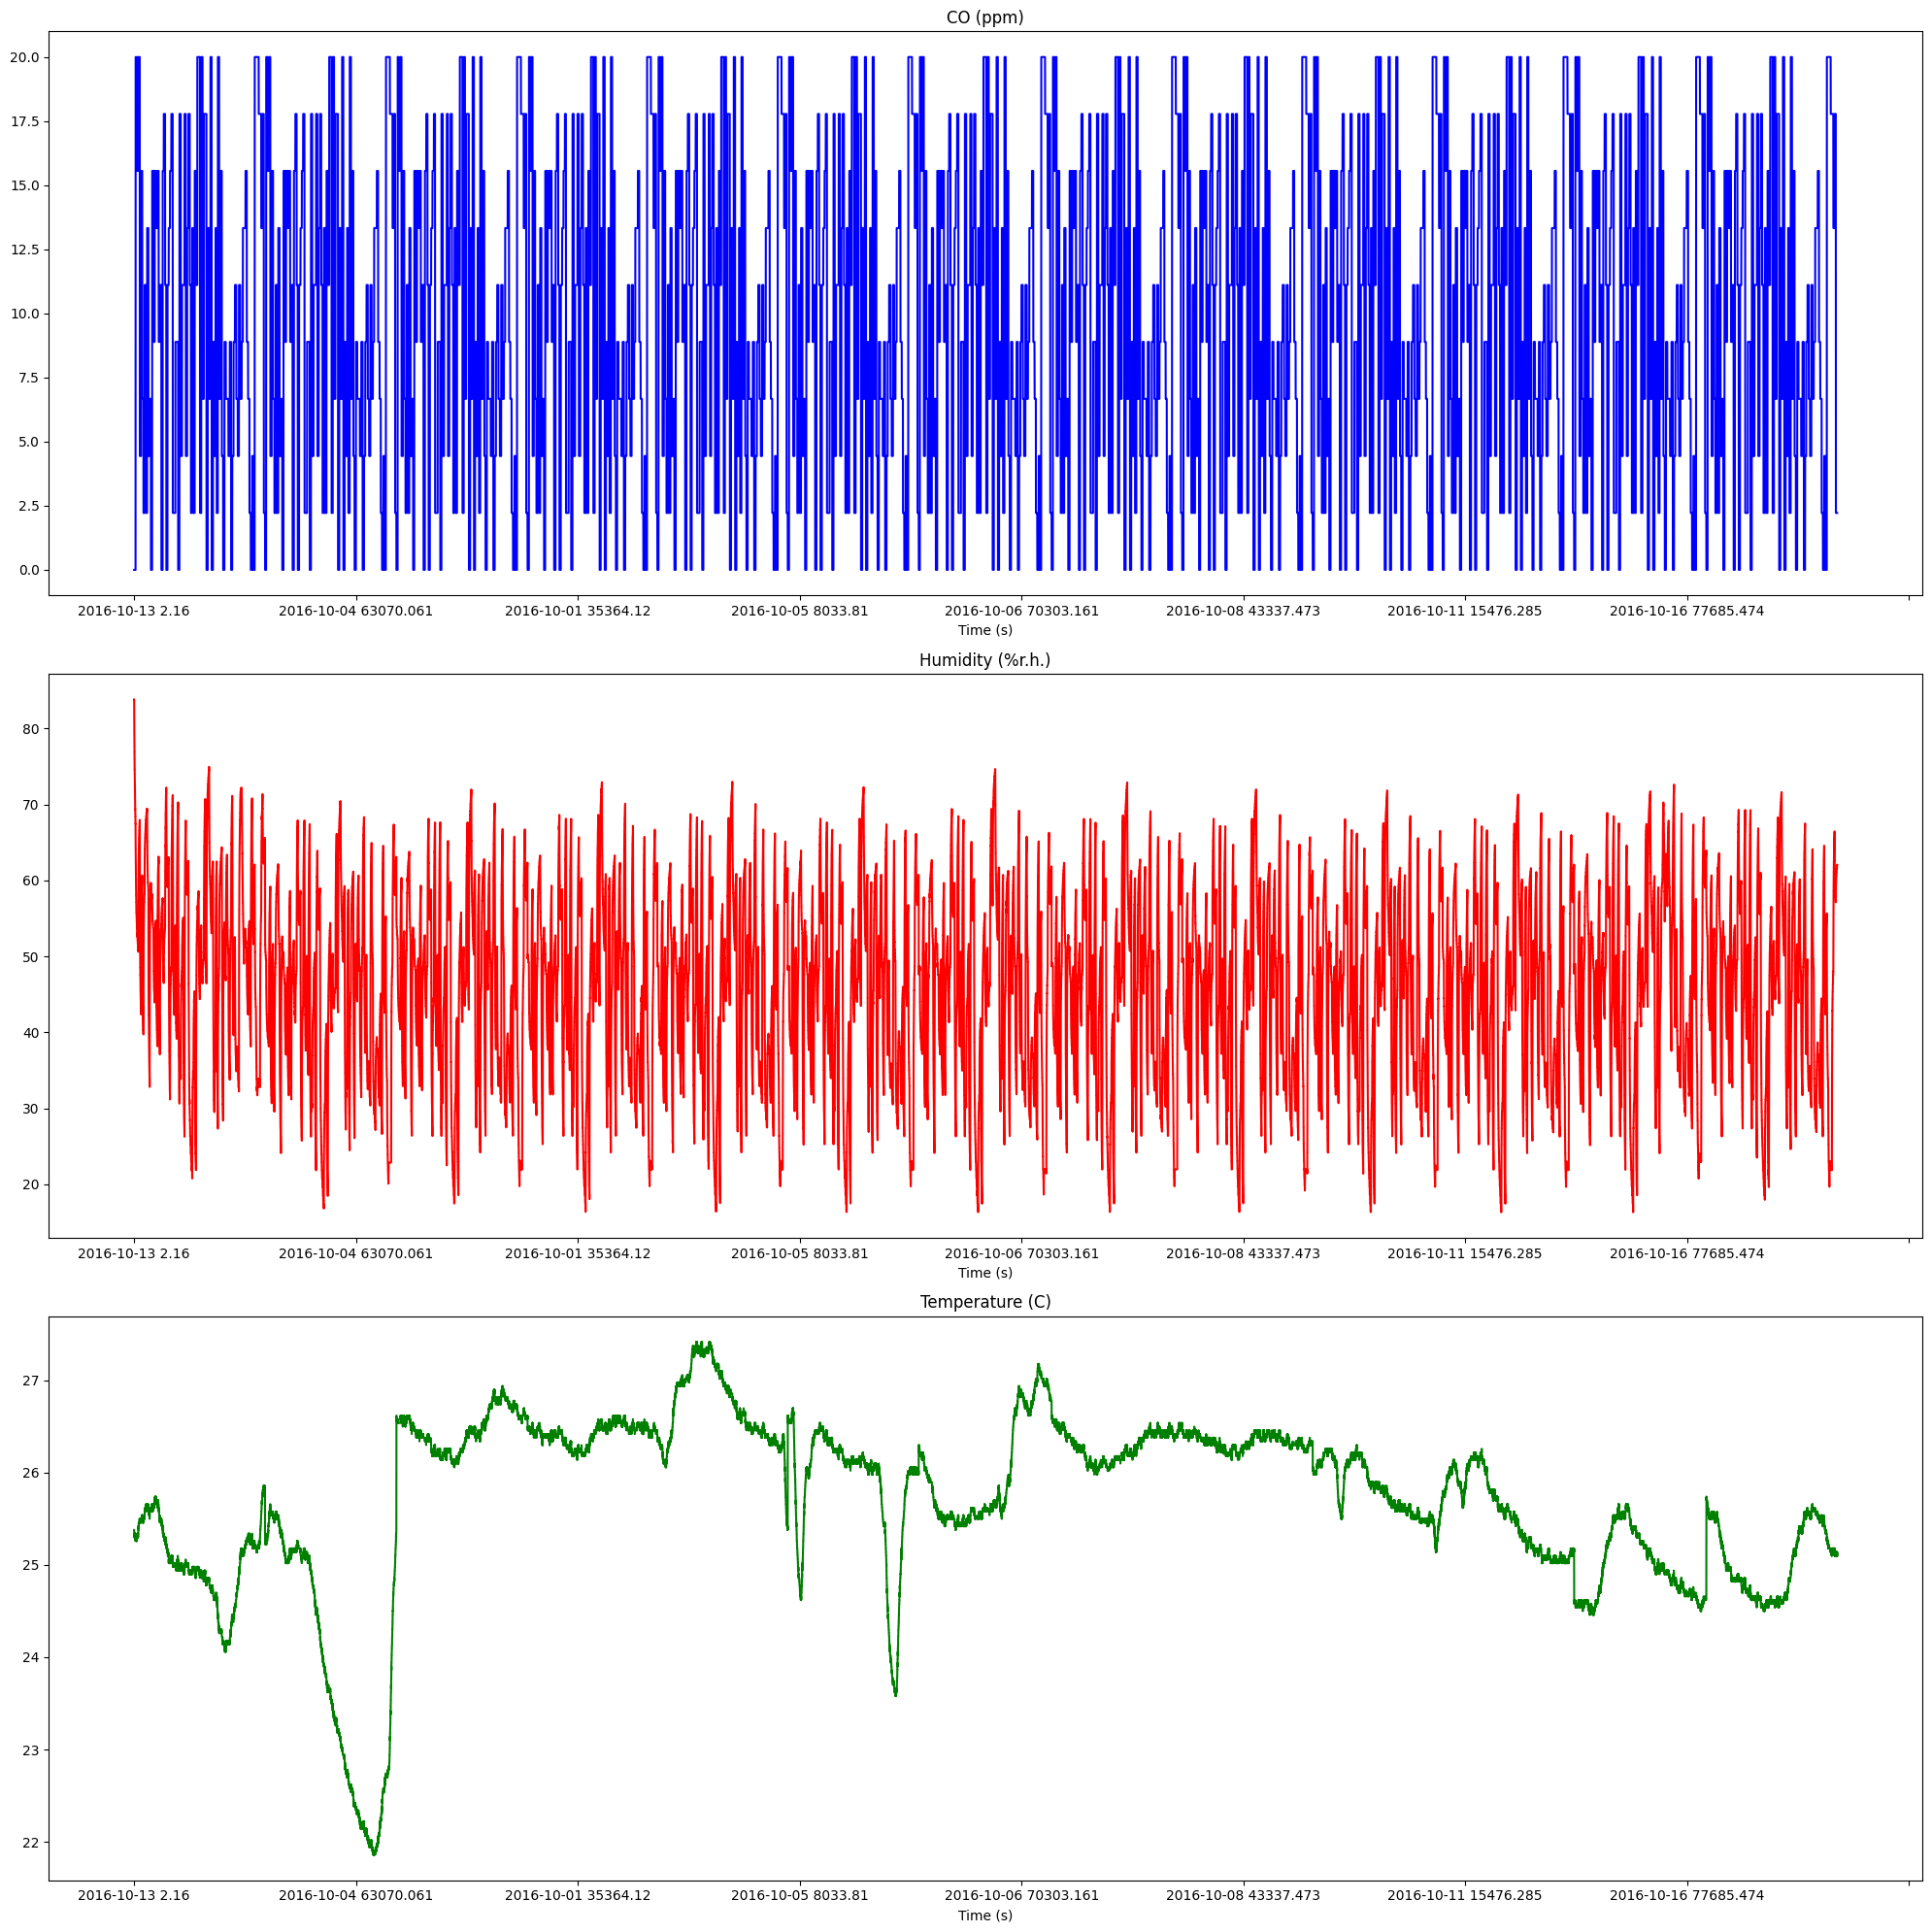

In [19]:
# Convert 'time' column to datetime if it's not already
#b['Time (s)'] = pd.to_datetime(b['Time (s)'], format='%Y-%m-%d %H.%f')

# Set 'time' column as index
b.set_index('Time (s)', inplace=True)

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))  # Increase the figure size to accommodate the third subplot

# Plot value1
b['CO (ppm)'].plot(ax=axes[0], color='blue')
axes[0].set_title('CO (ppm)')

# Plot value2
b['Humidity (%r.h.)'].plot(ax=axes[1], color='red')
axes[1].set_title('Humidity (%r.h.)')

# Plot value3
b['Temperature (C)'].plot(ax=axes[2], color='green')
axes[2].set_title('Temperature (C)')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [20]:
merge_df.show(50)

+-----------------+--------+----------------+---------------+------------------+------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+
|         Time (s)|CO (ppm)|Humidity (%r.h.)|Temperature (C)|Flow rate (mL/min)|Heater voltage (V)|R1 (MOhm)|R2 (MOhm)|R3 (MOhm)|R4 (MOhm)|R5 (MOhm)|R6 (MOhm)|R7 (MOhm)|R8 (MOhm)|R9 (MOhm)|R10 (MOhm)|R11 (MOhm)|R12 (MOhm)|R13 (MOhm)|R14 (MOhm)|
+-----------------+--------+----------------+---------------+------------------+------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+
|   2016-10-13 0.0|     0.0|         32.7023|         9.9032|          240.8069|              0.89|   0.0738|   0.1314|   0.0987|   0.0936|   0.1026|   0.1152|   0.1105|   0.0891|   0.0951|    0.1083|    0.1037|    0.1009|    0.0927|    0.1009|
| 2016-10-13 0.307| 

### Counting Distinct Values in DataFrame Columns
The provided code selects specific columns from the merged DataFrame merge_df and counts the number of distinct values in each column using the distinct() and count() functions.

This code snippet helps in understanding the uniqueness and diversity of values present in each specified column of the DataFrame, which is crucial for data exploration and analysis.



In [21]:
merge_df.select("`Humidity (%r.h.)`").distinct().count()

188499

In [22]:
merge_df.select("`Temperature (C)`").distinct().count()

35200

In [23]:
merge_df.select("`Heater voltage (V)`").distinct().count()

4823

In [24]:
merge_df.select("`CO (ppm)`").distinct().count()

3559

In [25]:
merge_df.select("`Flow rate (mL/min)`").distinct().count()

25767

### Categorizing CO Concentration Levels
The function categorize_CO(concentration) takes a concentration value as input and categorizes it into one of three levels based on predefined thresholds:

If the concentration is less than 5, it returns "Low_CO_Concentration".
If the concentration is between 5 (inclusive) and 10 (exclusive), it returns "Medium_CO_Concentration".
Otherwise, it returns "High_CO_Concentration".
This function is useful for classifying CO (carbon monoxide) concentration levels into meaningful categories, which can aid in analyzing and interpreting data related to air quality or gas sensor readings.

In [26]:
def categorize_CO(concentration):
    if concentration < 5:
        return "Low_CO_Concentration"
    elif concentration < 10:
        return "Medium_CO_Concentration"
    else:
        return "High_CO_Concentration"

### Applying User-Defined Function to Create Gas Mixture Type Column
The code snippet registers a User-Defined Function (UDF) named categorize_CO_udf, which categorizes CO concentration levels into low, medium, or high concentrations based on predefined thresholds. This UDF is applied to the 'CO (ppm)' column of the DataFrame merge_df to create a new column named 'Gas_Mixture_Type'.

In [27]:
# Register the UDF
categorize_CO_udf = F.udf(categorize_CO, StringType())

# Apply the UDF to create Gas_Mixture_Type column
merge_df = merge_df.withColumn('Gas_Mixture_Type', categorize_CO_udf(merge_df['CO (ppm)']))


In [28]:
merge_df

DataFrame[Time (s): string, CO (ppm): double, Humidity (%r.h.): double, Temperature (C): double, Flow rate (mL/min): double, Heater voltage (V): double, R1 (MOhm): double, R2 (MOhm): double, R3 (MOhm): double, R4 (MOhm): double, R5 (MOhm): double, R6 (MOhm): double, R7 (MOhm): double, R8 (MOhm): double, R9 (MOhm): double, R10 (MOhm): double, R11 (MOhm): double, R12 (MOhm): double, R13 (MOhm): double, R14 (MOhm): double, Gas_Mixture_Type: string]

### Renaming DataFrame Column
The provided code snippet renames the column 'Gas_Mixture_Type' in the DataFrame merge_df to 'lbl' using the withColumnRenamed() function.

In [29]:
merge_df = merge_df.withColumnRenamed("Gas_Mixture_Type", "lbl")

In [30]:
merge_df

DataFrame[Time (s): string, CO (ppm): double, Humidity (%r.h.): double, Temperature (C): double, Flow rate (mL/min): double, Heater voltage (V): double, R1 (MOhm): double, R2 (MOhm): double, R3 (MOhm): double, R4 (MOhm): double, R5 (MOhm): double, R6 (MOhm): double, R7 (MOhm): double, R8 (MOhm): double, R9 (MOhm): double, R10 (MOhm): double, R11 (MOhm): double, R12 (MOhm): double, R13 (MOhm): double, R14 (MOhm): double, lbl: string]

In [31]:
merge_df.select("lbl").distinct().show(20)

+--------------------+
|                 lbl|
+--------------------+
|Medium_CO_Concent...|
|Low_CO_Concentration|
|High_CO_Concentra...|
+--------------------+



### Analyzing Distribution of Gas Mixture Types
The code snippet calculates the distribution of gas mixture types in the DataFrame merge_df. It first groups the data by the 'lbl' column (previously 'Gas_Mixture_Type') and counts the occurrences of each type using the groupBy() and count() functions.

In [32]:
from pyspark.sql.functions import desc

distribution = merge_df.groupBy("lbl").count()

sorted_distribution = distribution.orderBy(desc("count"))

sorted_distribution.show()

+--------------------+-------+
|                 lbl|  count|
+--------------------+-------+
|High_CO_Concentra...|1902199|
|Low_CO_Concentration|1179175|
|Medium_CO_Concent...| 761786|
+--------------------+-------+



In [33]:
merge_df.count()

3843160

In [34]:
merge_df.show()

+----------------+--------+----------------+---------------+------------------+------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+--------------------+
|        Time (s)|CO (ppm)|Humidity (%r.h.)|Temperature (C)|Flow rate (mL/min)|Heater voltage (V)|R1 (MOhm)|R2 (MOhm)|R3 (MOhm)|R4 (MOhm)|R5 (MOhm)|R6 (MOhm)|R7 (MOhm)|R8 (MOhm)|R9 (MOhm)|R10 (MOhm)|R11 (MOhm)|R12 (MOhm)|R13 (MOhm)|R14 (MOhm)|                 lbl|
+----------------+--------+----------------+---------------+------------------+------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+--------------------+
|  2016-10-13 0.0|     0.0|         32.7023|         9.9032|          240.8069|              0.89|   0.0738|   0.1314|   0.0987|   0.0936|   0.1026|   0.1152|   0.1105|   0.0891|   0.0951|    0.1083|    0.

In [35]:
df_pd = sorted_distribution.toPandas()

In [36]:
df_pd

,lbl,count
0,High_CO_Concentration,1902199
1,Low_CO_Concentration,1179175
2,Medium_CO_Concentration,761786


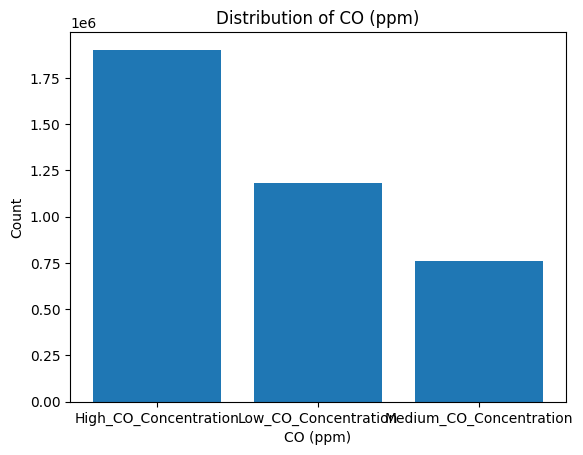

In [37]:
plt.bar(df_pd['lbl'], df_pd['count'])
plt.xticks(df_pd['lbl'])
plt.xlabel("CO (ppm)")
plt.ylabel("Count")
plt.title("Distribution of CO (ppm)")
plt.show()

In [38]:
features = merge_df.columns[6:-1]

In [39]:
len(features)

14

In [40]:
assembler = VectorAssembler(
    inputCols = features,
    outputCol='features')

vector_df = assembler.transform(merge_df)

### Report: Distribution of CO (ppm)
The bar chart below illustrates the distribution of CO (carbon monoxide) concentration levels across different gas mixture types in the dataset. The x-axis represents the gas mixture types, while the y-axis indicates the count of occurrences for each type. This visualization offers insights into the prevalence of various CO concentration levels, facilitating a better understanding of the dataset's composition and distribution characteristics.

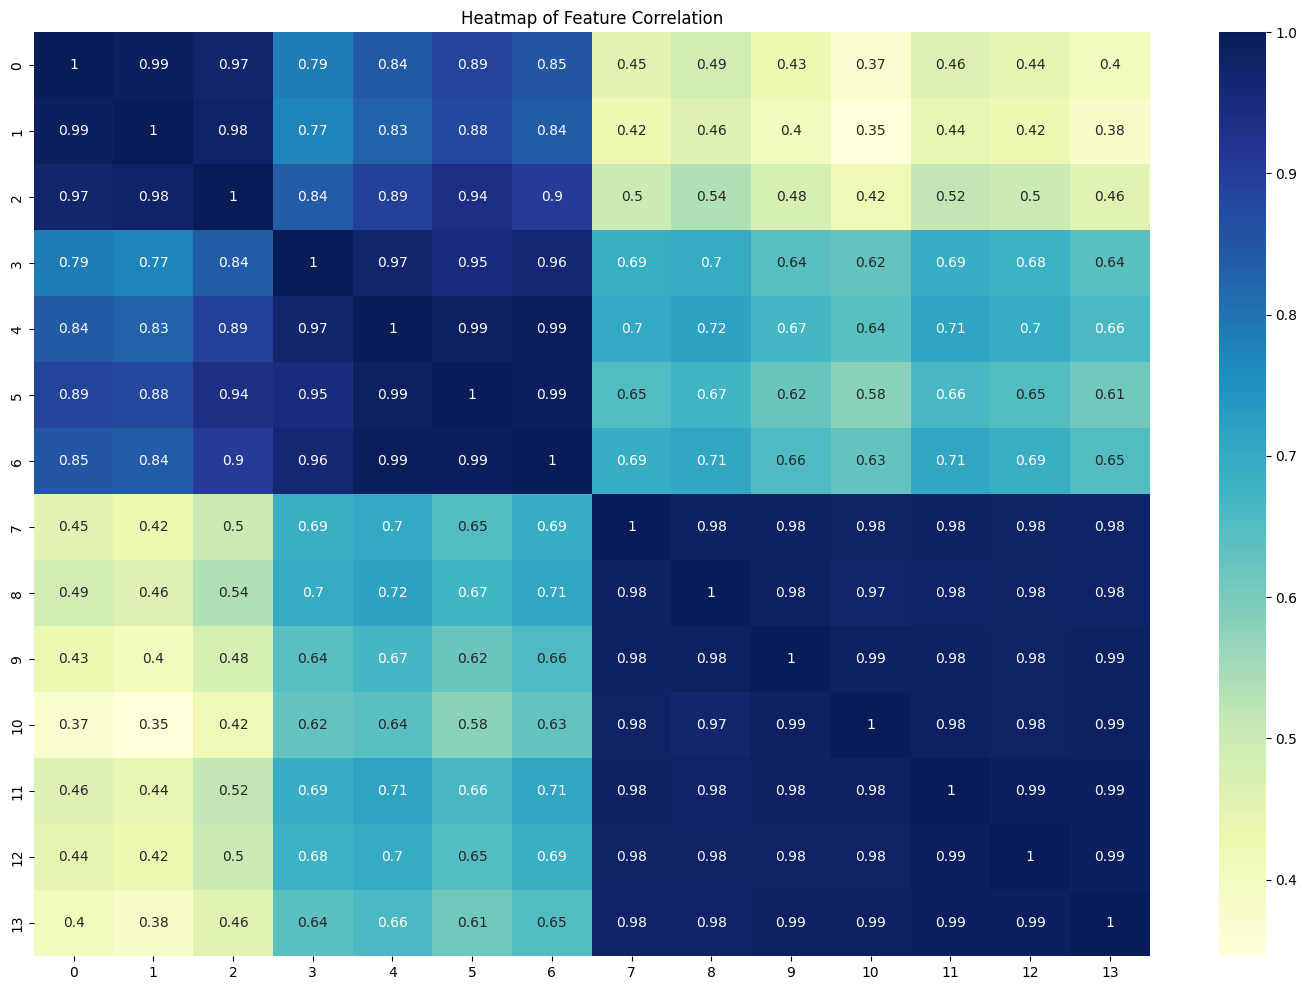

In [41]:
pearsonCorr = Correlation.corr(vector_df, "features").head()[0]

corr_df = pd.DataFrame(pearsonCorr.toArray())

plt.figure(figsize=(18,12))
sns.heatmap(corr_df, annot=True, cmap='YlGnBu')
plt.title('Heatmap of Feature Correlation')
plt.show()

In [42]:
df

DataFrame[Time (s): string, CO (ppm): double, Humidity (%r.h.): double, Temperature (C): double, Flow rate (mL/min): double, Heater voltage (V): double, R1 (MOhm): double, R2 (MOhm): double, R3 (MOhm): double, R4 (MOhm): double, R5 (MOhm): double, R6 (MOhm): double, R7 (MOhm): double, R8 (MOhm): double, R9 (MOhm): double, R10 (MOhm): double, R11 (MOhm): double, R12 (MOhm): double, R13 (MOhm): double, R14 (MOhm): double]

In [43]:
# co_gt_1000_rows = co_gt_1000_rows.drop('count')

### Data Splitting
The dataset has been split into two subsets: train_data and test_data. These subsets will be used for training and testing machine learning models, respectively. This splitting process is essential for evaluating model performance on unseen data and ensuring the generalizability of the trained models.



In [44]:
(train_data, test_data) = merge_df.randomSplit([0.7, 0.3])

### Feature Engineering Report
The feature engineering process involves assembling multiple input feature columns into a single vector column using VectorAssembler. This consolidation simplifies the data representation for machine learning algorithms. Additionally, the assembled features are scaled using StandardScaler to ensure uniformity in feature magnitudes, optimizing model training and performance.

In [45]:
assembler = VectorAssembler(inputCols=features, outputCol='features')

scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')

In [46]:
labelIndexer = StringIndexer(inputCol="lbl", outputCol="indexedLabel").fit(merge_df)

### Decision Tree Classifier Training Pipeline
A decision tree classifier is trained using a pipeline consisting of feature assembly, scaling, label indexing, and model training stages. This streamlined workflow ensures efficient preprocessing and model training without explicitly defining each step.

In [47]:
dt_classifier = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='scaledFeatures')
pipeline = Pipeline(stages=[assembler, labelIndexer, scaler, dt_classifier])
dt_model = pipeline.fit(train_data)

In [48]:
predictions = dt_model.transform(test_data)

### Model Evaluation: Accuracy
The BinaryClassificationEvaluator is used to evaluate the accuracy of the trained model's predictions. It compares the predicted labels (predictionCol) with the actual labels (labelCol) and computes the accuracy metric. The resulting accuracy score provides insight into the model's performance in correctly classifying instances.

In [49]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [50]:
evaluator = BinaryClassificationEvaluator(labelCol='indexedLabel', rawPredictionCol='prediction', metricName='areaUnderPR')

accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8617619455106162


### Random Forest Classifier Training
A Random Forest classifier is trained using a pipeline that includes feature assembly, label indexing, feature scaling, and model training stages. The trained model (rf_model) is fitted to the training data (train_data) to predict the target labels based on the scaled features.

In [51]:
rfClassifier = RandomForestClassifier(labelCol="indexedLabel", featuresCol="scaledFeatures")
pipeline = Pipeline(stages=[assembler, labelIndexer, scaler, rfClassifier])
rf_model = pipeline.fit(train_data)

In [52]:
rf_predictions = rf_model.transform(test_data)

In [53]:
evaluator = BinaryClassificationEvaluator(labelCol='indexedLabel', rawPredictionCol='prediction', metricName='areaUnderPR')
accuracy = evaluator.evaluate(rf_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8747693987890441


### Logistic Regression Classifier Training
A Logistic Regression classifier is trained using a pipeline that includes feature assembly, label indexing, feature scaling, and model training stages. The trained model (lr_model) is fitted to the training data (train_data) to predict the target labels based on the scaled features.

In [54]:
lrClassifier = LogisticRegression(labelCol="indexedLabel", featuresCol="scaledFeatures")
pipeline = Pipeline(stages=[assembler, labelIndexer, scaler, lrClassifier])
lr_model = pipeline.fit(train_data)

In [55]:
lr_predictions = lr_model.transform(test_data)

In [56]:
evaluator = BinaryClassificationEvaluator(labelCol='indexedLabel', rawPredictionCol='prediction', metricName='areaUnderPR')
accuracy = evaluator.evaluate(lr_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8304889091632621


### Naive Bayes Classifier Training
A Naive Bayes classifier is trained using a pipeline that incorporates feature assembly, label indexing, feature scaling, and model training stages. The resultant model (naive_model) is applied to the training data (train_data) to predict the target labels based on the scaled features.

In [57]:
naiveClassifier = NaiveBayes(labelCol="indexedLabel", featuresCol="scaledFeatures")
pipeline = Pipeline(stages=[assembler, labelIndexer, scaler, naiveClassifier])
naive_model = pipeline.fit(train_data)

In [58]:
naive_predictions = naive_model.transform(test_data)

In [59]:
evaluator = BinaryClassificationEvaluator(labelCol='indexedLabel', rawPredictionCol='prediction', metricName='areaUnderPR')
accuracy = evaluator.evaluate(naive_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.6918652789187736


## Experiment

In [69]:
features = merge_df.columns[9:-1]

In [70]:
assembler = VectorAssembler(
    inputCols = features,
    outputCol='features')

vector_df = assembler.transform(merge_df)

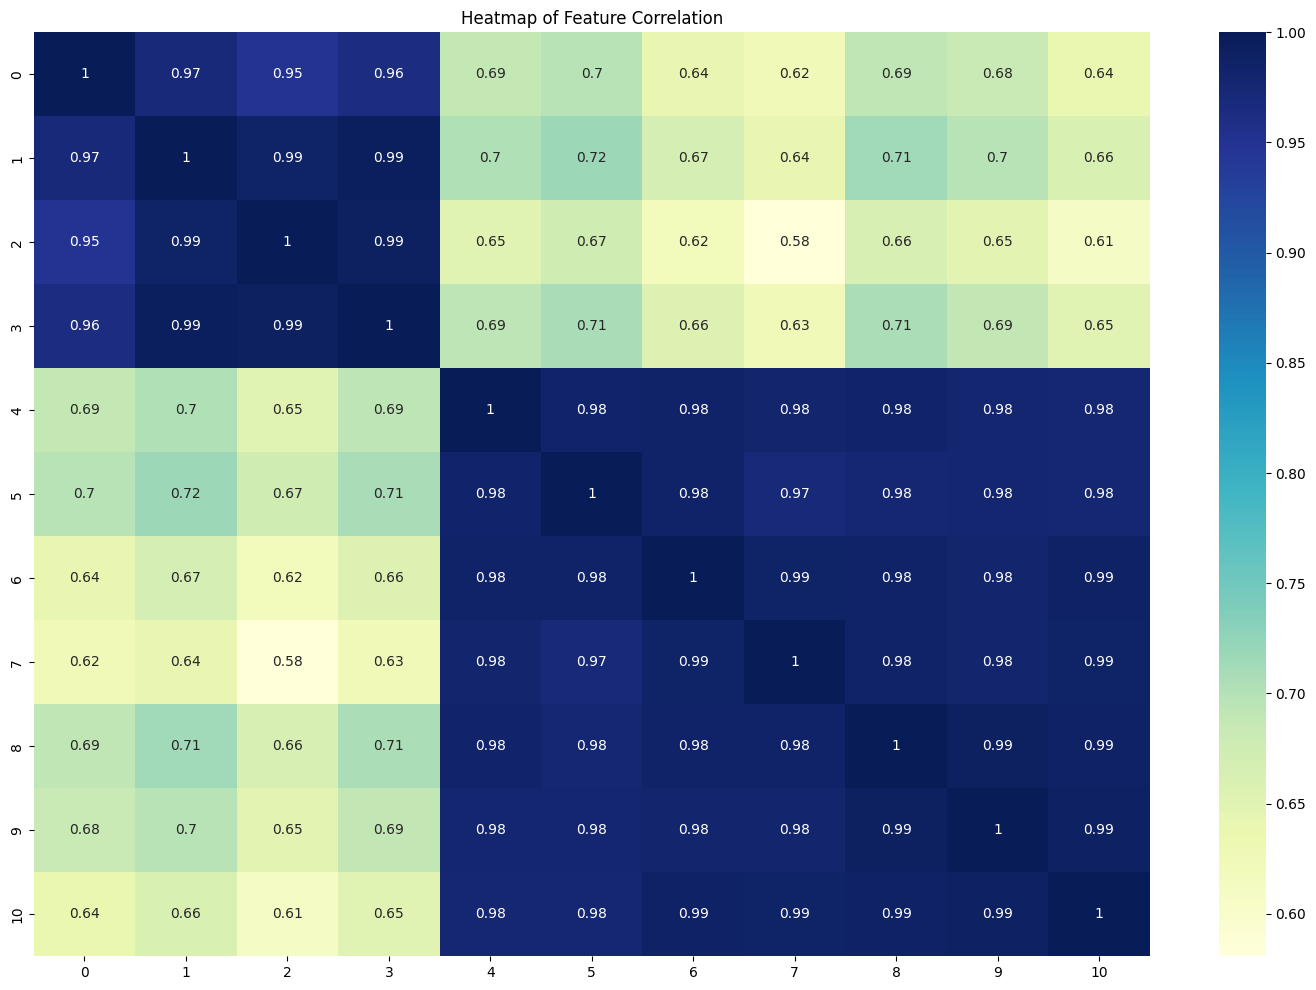

In [71]:
pearsonCorr = Correlation.corr(vector_df, "features").head()[0]

corr_df = pd.DataFrame(pearsonCorr.toArray())

plt.figure(figsize=(18,12))
sns.heatmap(corr_df, annot=True, cmap='YlGnBu')
plt.title('Heatmap of Feature Correlation')
plt.show()

In [72]:
(train_data, test_data) = merge_df.randomSplit([0.7, 0.3])

In [73]:
assembler = VectorAssembler(inputCols=features, outputCol='features')

scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')

In [74]:
labelIndexer = StringIndexer(inputCol="lbl", outputCol="indexedLabel").fit(merge_df)

In [75]:
dt_classifier = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='scaledFeatures')
pipeline = Pipeline(stages=[assembler, labelIndexer, scaler, dt_classifier])
dt_model = pipeline.fit(train_data)

In [76]:
predictions = dt_model.transform(test_data)

In [77]:
evaluator = BinaryClassificationEvaluator(labelCol='indexedLabel', rawPredictionCol='prediction', metricName='areaUnderPR')

accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.859022841543027


In [78]:
rfClassifier = RandomForestClassifier(labelCol="indexedLabel", featuresCol="scaledFeatures")
pipeline = Pipeline(stages=[assembler, labelIndexer, scaler, rfClassifier])
rf_model = pipeline.fit(train_data)

In [79]:
rf_predictions = rf_model.transform(test_data)

In [80]:
evaluator = BinaryClassificationEvaluator(labelCol='indexedLabel', rawPredictionCol='prediction', metricName='areaUnderPR')
accuracy = evaluator.evaluate(rf_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8651467750054559


In [81]:
lrClassifier = LogisticRegression(labelCol="indexedLabel", featuresCol="scaledFeatures")
pipeline = Pipeline(stages=[assembler, labelIndexer, scaler, lrClassifier])
lr_model = pipeline.fit(train_data)

In [82]:
lr_predictions = lr_model.transform(test_data)

In [92]:
evaluator = BinaryClassificationEvaluator(labelCol='indexedLabel', rawPredictionCol='prediction', metricName='areaUnderPR')
accuracy = evaluator.evaluate(lr_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8279444349855956


In [84]:
naiveClassifier = NaiveBayes(labelCol="indexedLabel", featuresCol="scaledFeatures")
pipeline = Pipeline(stages=[assembler, labelIndexer, scaler, naiveClassifier])
naive_model = pipeline.fit(train_data)

In [85]:
naive_predictions = naive_model.transform(test_data)

In [86]:
evaluator = BinaryClassificationEvaluator(labelCol='indexedLabel', rawPredictionCol='prediction', metricName='areaUnderPR')
accuracy = evaluator.evaluate(naive_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.6636767072994931
